# Flow Matching Example

Based on this blog post https://jmtomczak.github.io/blog/18/18_fm.html#:~:text=Please%20note%20that%20in%20the,in%20score-based%20generative%20models and JAX code from David Yallup but adapted into pytorch.

Begin by importing libaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch

Define some data and a noise distribution for smoothing.

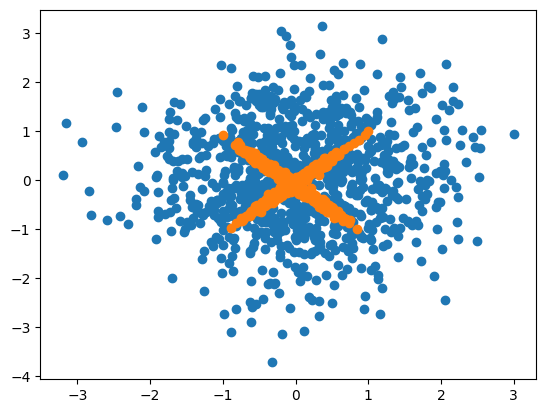

In [2]:
# example data

#x = np.random.normal(0, 1, 1000)
#y = np.random.normal(x**2, 0.1)

from lsbi.stats import mixture_normal

dist = mixture_normal([0,0], [[0,0],[0,0]], 
                      np.array([[[1, 0.99],[0.99, 1]],[[1, -0.99],[-0.99, 1]]]))
samples = dist.rvs(1000)
x = samples[:, 0]
y = samples[:, 1]

noise_distribution = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], 1000)

plt.scatter(noise_distribution[:, 0], noise_distribution[:, 1])

normx = 2*(x - x.min()) / (x.max() - x.min()) - 1
normy = 2*(y - y.min()) / (y.max() - y.min()) - 1
plt.scatter(normx, normy)


Build the pytorch network.

In [3]:
class net(nn.Module):
    def __init__(self, input_dim, num_layers, hlsize):
        super(net, self).__init__()

        self.fc = [nn.Linear(input_dim+1, hlsize),
                     nn.ReLU()]
        for i in range(num_layers):
            self.fc.append(nn.Linear(hlsize, hlsize))
            self.fc.append(nn.ReLU())
        self.fc.append(nn.Linear(hlsize, input_dim))

        self.network = nn.Sequential(*self.fc)
        
    def forward(self, x):
        x = self.network(x)
        return x

lr = 0.001
batch_size=25 # need to implement batching
num_layers = 5
input_dim = 2
hlsize = 100

model = net(input_dim, num_layers, hlsize)
print(model)

net(
  (network): Sequential(
    (0): Linear(in_features=3, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): ReLU()
    (10): Linear(in_features=100, out_features=100, bias=True)
    (11): ReLU()
    (12): Linear(in_features=100, out_features=2, bias=True)
  )
)


Train the network

/var/folders/pk/s11gmpgj1_d0jt1ykgfx7rt80000gn/T/ipykernel_5902/565810563.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x0)
/var/folders/pk/s11gmpgj1_d0jt1ykgfx7rt80000gn/T/ipykernel_5902/565810563.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1 = torch.tensor(x1)


Epoch:  0 Loss:  0.9412867054343224  Best Loss:  inf  Count:  0
Epoch:  1 Loss:  0.5904404275119305  Best Loss:  0.9412867054343224  Count:  0
Epoch:  2 Loss:  0.5705904789268971  Best Loss:  0.5904404275119305  Count:  0
Epoch:  3 Loss:  0.5451434709131717  Best Loss:  0.5705904789268971  Count:  0
Epoch:  4 Loss:  0.5696183402091265  Best Loss:  0.5451434709131717  Count:  0
Epoch:  5 Loss:  0.5652485162019729  Best Loss:  0.5451434709131717  Count:  1
Epoch:  6 Loss:  0.547391015291214  Best Loss:  0.5451434709131717  Count:  2
Epoch:  7 Loss:  0.5430607851594687  Best Loss:  0.5451434709131717  Count:  3
Epoch:  8 Loss:  0.5212619598954916  Best Loss:  0.5430607851594687  Count:  0
Epoch:  9 Loss:  0.5155947752296924  Best Loss:  0.5212619598954916  Count:  0
Epoch:  10 Loss:  0.5193338710814714  Best Loss:  0.5155947752296924  Count:  0
Epoch:  11 Loss:  0.518064308166504  Best Loss:  0.5155947752296924  Count:  1
Epoch:  12 Loss:  0.5193907618522644  Best Loss:  0.515594775229692

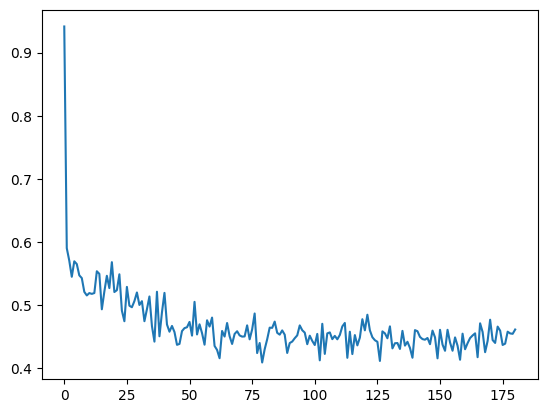

In [4]:
epochs = 500
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def loss(x0, x1, sigma0):

    # x0 is noise and x1 is the data distribution
    x0 = torch.tensor(x0)
    x1 = torch.tensor(x1)
    t = torch.rand((batch_size, 1))
    noise = torch.randn((batch_size, 2))
    # the mean of the probability path P(x|z)
    # interpolation between noise and data distribution
    # where x0 is the noise distribution and x1 is the data distribution
    psi0 = t * x1 + (1 - t) * x0 
    # the standard deviation is just a constant times standard normal
    smoothing = sigma0 * noise
    # adding the gaussian noise to the mean
    psi0 = psi0 + smoothing
    output = model(torch.tensor(np.column_stack((psi0, t)).astype(np.float32)))
    psi = x1 - x0
    return (output - psi).pow(2).mean()


from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(torch.tensor(np.column_stack((noise_distribution, normx, normy)).astype(np.float32)))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

sigma0 = 0.001
patience = 100
c = np.inf
count = 0
loss_history = []
for i in range(epochs):
    loss_over_batch = []
    for batch_X in train_loader:
        optimizer.zero_grad()
        l = loss(batch_X[0][:, :2], batch_X[0][:, 2:], sigma0)
        l.backward()
        optimizer.step()
        loss_over_batch.append(l.item())
    print('Epoch: ', str(i) + ' Loss: ', np.mean(loss_over_batch), ' Best Loss: ', c, ' Count: ', count)
    loss_history.append(np.mean(loss_over_batch))
    if loss_history[-1] < c:
        c = loss_history[-1]
        best_model = model.state_dict()
        count = 0
    else:
        count += 1
    if count > patience:
        break

model.load_state_dict(best_model)

plt.plot(loss_history)


Make predictions for samples with the network. Using Euler method for solvign the ODE.

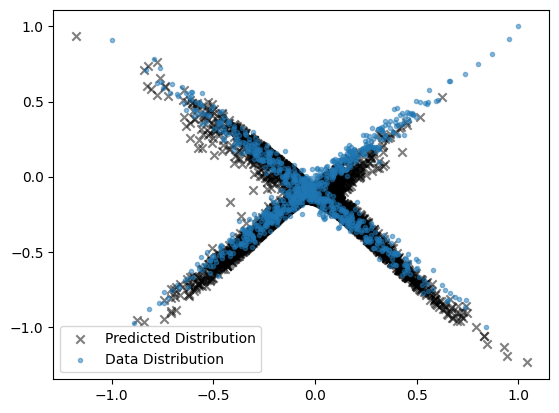

In [7]:
def predict(x0, x1, sigma0, t):
    x0 = torch.tensor(x0)
    x1 = torch.tensor(x1)
    t = torch.tensor(np.array([t]*len(x0)).reshape(-1, 1))
    noise = torch.randn((len(x0), 2))
    psi0 = t * x1 + (1 - t) * x0 + sigma0 * noise
    output = model(torch.tensor(np.column_stack((psi0, t)).astype(np.float32)))
    #print((output - (x1 - x0)).pow(2).mean())
    return output.detach().numpy()

#xtest = np.random.normal(0, 1, (1000, 2))
test_noise_distribution = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], 10000)
xtest = test_noise_distribution.copy()
t = np.linspace(0, 1, 100)
deltat = np.diff(t)[0]

for i in range(len(t)):
    xprime = xtest + predict(
        test_noise_distribution, xtest, sigma0, t[i])*deltat
    xtest = xprime.copy()

    """if i%100 == 0:
        plt.scatter(xtest[:, 0], xtest[:, 1], c='r', alpha=0.1)"""
plt.scatter(xtest[:, 0], xtest[:, 1], c='k', alpha=0.5, marker='x', label='Predicted Distribution')
plt.scatter(normx, normy, alpha=0.5, marker='.', label='Data Distribution')
plt.legend()


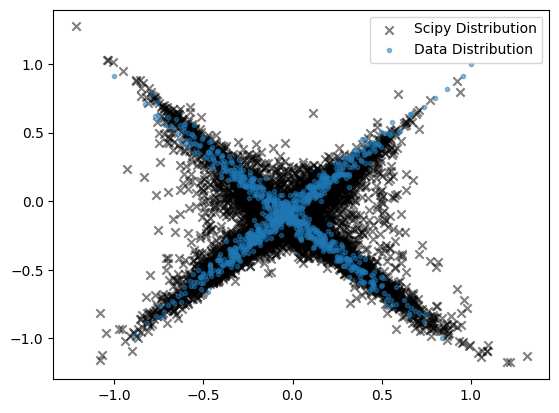

In [8]:
from scipy.integrate import solve_ivp

def func(t, x):
    # hmm not sure about this... might not need the psi0 bit...
    x = x.reshape(-1, 2)
    t = np.array([t]*len(x)).reshape(-1, 1)
    return model(torch.tensor(np.column_stack((x, t)).astype(np.float32))).detach().numpy().flatten()

t = np.linspace(0, 1, 100)
sol = solve_ivp(func, (0, 1), test_noise_distribution.flatten(), t_eval=t)
solution = sol.y[:,-1].reshape(-1, 2)

plt.scatter(solution[:, 0], solution[:, 1], c='k', alpha=0.5, marker='x', label='Scipy Distribution')
plt.scatter(normx, normy, alpha=0.5, marker='.', label='Data Distribution')
plt.legend()

Want to also be able to calculate log probabilities...

Do this with the Hutchinson's trace estimator $\ln p_1 (\hat{x}_1) \approx \ln p_0 (\hat{x}_0) - f_0$ where $\hat{x}_1$ is a data point, $\hat{x}_0$ is the corresponding point in the noise distribution and $f_0$ is an approximation of the trace of the vector field jacobian.

tensor([[ 0.4401, -0.6295,  0.8889],
        [ 0.3276, -0.4977,  0.8889],
        [ 0.1275, -0.2125,  0.8889],
        ...,
        [-0.0982,  0.0262,  0.8889],
        [-0.1262,  0.0164,  0.8889],
        [ 0.4445,  0.4008,  0.8889]])
tensor([[ 0.4886, -0.6366,  0.7778],
        [ 0.3665, -0.4925,  0.7778],
        [ 0.0909, -0.2027,  0.7778],
        ...,
        [-0.0714, -0.0397,  0.7778],
        [-0.0891, -0.0334,  0.7778],
        [ 0.4678,  0.3664,  0.7778]], grad_fn=<CatBackward0>)
tensor([[ 0.4453, -0.5931,  0.6667],
        [ 0.3097, -0.4310,  0.6667],
        [ 0.0610, -0.1857,  0.6667],
        ...,
        [-0.0539, -0.0712,  0.6667],
        [-0.0665, -0.0655,  0.6667],
        [ 0.3776,  0.2793,  0.6667]], grad_fn=<CatBackward0>)
tensor([[ 0.3649, -0.4960,  0.5556],
        [ 0.2470, -0.3688,  0.5556],
        [ 0.0386, -0.1912,  0.5556],
        ...,
        [-0.0493, -0.0954,  0.5556],
        [-0.0571, -0.0894,  0.5556],
        [ 0.2916,  0.1745,  0.5556]], grad_fn=

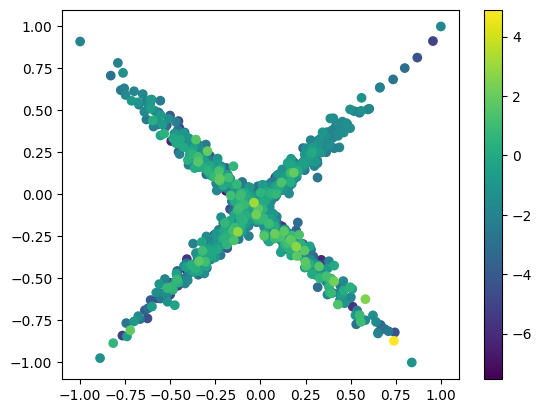

In [24]:
def log_p_base(x, reduction='sum', dim=1):
    log_p = -0.5 * torch.log(2. * torch.tensor(np.pi)) - 0.5 * x**2.
    if reduction == 'mean':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p
        
def log_prob(x_1, reduction='mean', time_samples=10):
    # backward Euler (see Appendix C in Lipman's paper)
    ts = torch.linspace(1., 0., time_samples)
    delta_t = ts[1] - ts[0]
    
    for t in ts:
        if t == 1.:
            x_t = x_1 * 1.
            f_t = 0.
        else:
            # Calculate phi_t
            t_embedding = torch.Tensor([t]*len(x_t)).reshape(-1, 1)
            data_stack = torch.cat((x_t, t_embedding), dim=1)
            print(data_stack)
            x_t =x_t - model(data_stack) * delta_t
            
            # Calculate f_t
            # approximate the divergence using the Hutchinson trace estimator and the autograd
            model.eval()  # set the vector field net to evaluation
            
            x = torch.FloatTensor(data_stack.data)  # copy the original data (it doesn't require grads!)
            x.requires_grad = True 
            
            e = torch.randn_like(x)  # epsilon ~ Normal(0, I) 
            
            e_grad = torch.autograd.grad(model(x).sum(), x, create_graph=True)[0]
            e_grad_e = e_grad * e
            f_t = e_grad_e.view(x.shape[0], -1).sum(dim=1)

            model.eval()  # set the vector field net to train again
    
    log_p_1 = log_p_base(x_t, reduction='sum') - f_t
    
    if reduction == "mean":
        return log_p_1.mean()
    elif reduction == "sum":
        return log_p_1.sum()
    else:
        return log_p_1
    
probs = log_prob(torch.tensor(np.column_stack((normx, normy)).astype(np.float32)), reduction=None)
args = torch.argsort(probs)
normx = normx[args]
normy = normy[args]
probs = probs[args]

plt.scatter(normx, normy, c=probs.detach().numpy(), cmap='viridis')
plt.colorbar()
plt.show()
